In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns

In [2]:
import dataloading

In [43]:
sentences_train = dataloading.load_raw_dataset('train')
sentences_eval = dataloading.load_raw_dataset('eval')

In [44]:
all_data = np.concatenate(sentences_train, axis=1)
all_words = all_data[0, :]
all_pos = all_data[1, :]
all_labels =  all_data[-1, :].astype(int)
len(all_words), len(all_pos), len(all_labels)

(203621, 203621, 203621)

In [ ]:
sentences_train

In [48]:
all_lengths = np.concatenate([[len(sentence[0]) for word in sentence[0] ]for sentence in sentences_train])
len(all_lengths)

203621

In [49]:
sentences_df = pd.DataFrame({'word': all_words, 'pos': all_pos, 'label': all_labels, 'sentence len': all_lengths})

In [227]:
sentences_df

,word,pos,label,sentence len,word len,first letter
0,EU,NNP,1,9,2,e
1,rejects,VBZ,0,9,7,r
2,German,JJ,1,9,6,g
3,call,NN,0,9,4,c
4,to,TO,0,9,2,t
...,...,...,...,...,...,...
203616,three,CD,0,2,5,t
203617,Swansea,NN,1,4,7,s
203618,1,CD,0,4,1,1
203619,Lincoln,NNP,1,4,7,l


In [11]:
name_pos_arr = sentences_df[sentences_df['label']==1]['pos']
not_name_pos_arr = sentences_df[sentences_df['label']==0]['pos']

In [18]:
%config InlineBackend.figure_formats = ['svg']
import matplotlib
# %matplotlib inline
matplotlib.style.use('dark_background')

Text(0.5, 1.0, 'Count plot for entity POS')

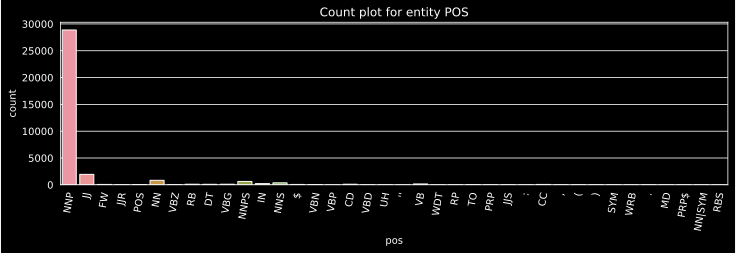

In [19]:
import seaborn as sns
plt.figure(figsize=(12,3))
sns.countplot(x=name_pos_arr)
plt.xticks(rotation = 80);
plt.title(f'Count plot for entity POS')

/home/jonaf/projects/venvs/venv39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Count plot for NON entity POS')

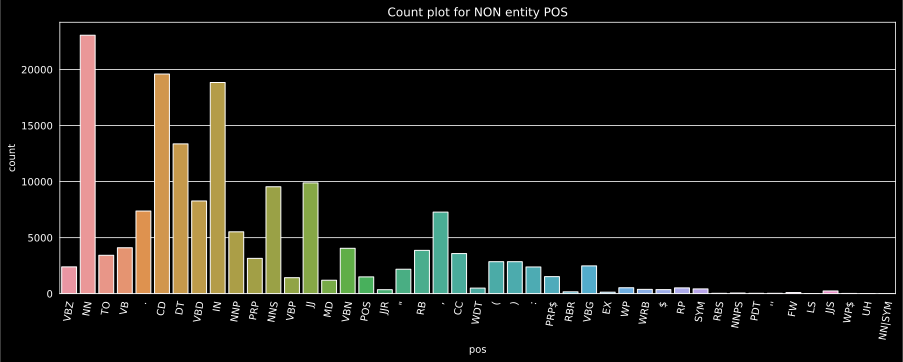

In [20]:
plt.figure(figsize=(15,5))
sns.countplot(not_name_pos_arr)
plt.xticks(rotation = 80);
plt.title(f'Count plot for NON entity POS')


Text(0.5, 1.0, 'Count plot for entity POS')

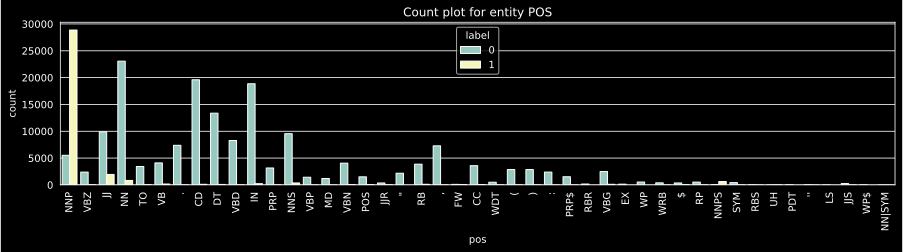

In [229]:
plt.figure(figsize=(15,3))
sns.countplot(data=sentences_df, x='pos', hue='label')
plt.xticks(rotation = 90);
plt.title(f'Count plot for entity POS')

In [230]:
feature_maps = [lambda sentence: [word[0].isupper() for word in sentence[0]],
                    lambda sentence: [ii for ii in range(len(sentence[0]))],
                    lambda sentence: [True if pos in ('NNP', 'NNPS', 'JJS') else False for pos in sentence[1]],
                    lambda sentence: [True if pos in ('NN', 'CD', 'IN', 'DT') else False for pos in sentence[1]],
                    lambda sentence: [True if last_pos == 'NNP' else False for last_pos in sentence[2]],
                    lambda sentence: [True if next_pos == 'NNP' else False for next_pos in sentence[3]],
                    lambda sentence: [len(word) for word in sentence[0]],
                    lambda sentence: [len(sentence[0]) for word in sentence[0]],
                    lambda sentence: [word[0].lower() in 't,f.o' for word in sentence[0]],
                    lambda sentence: [word[0].lower() in 'jkyzv' for word in sentence[0]]                      ]

In [231]:
X_train, y_train = dataloading.convert_raw_to_features(sentences_train, feature_maps)
X_eval, y_eval = dataloading.convert_raw_to_features(sentences_eval, feature_maps)


In [232]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# model = RandomForestClassifier(n_estimators=200, max_depth=2, random_state=42)
model = RandomForestClassifier(n_estimators=300, max_depth=13, random_state=42)
# model = AdaBoostClassifier(n_estimators=150)
# model = GradientBoostingClassifier(max_depth=15)
# model = KNeighborsClassifier(n_neighbors=7)
# model = SVC(kernel='rbf')

model.fit(X_train, y_train)
score = model.score(X_eval, y_eval)
score

0.9700946224835482

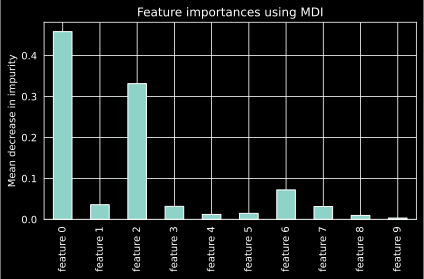

In [207]:
feature_names = [f"feature {i}" for i in range(X_eval.shape[1])]
importances = model.feature_importances_
# std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

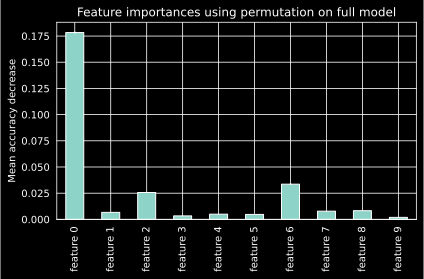

In [196]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_eval, y_eval)
forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [110]:
df = pd.DataFrame({'x': X_train[:,0], 'y':y_train})

In [104]:
df

,x,y
0,1,1
1,0,0
2,1,1
3,0,0
4,0,0
...,...,...
203616,0,0
203617,1,1
203618,0,0
203619,1,1


Text(0.5, 0, 'starts with Caps')

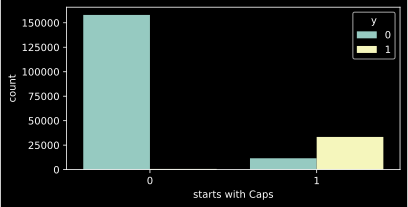

In [105]:
plt.figure(figsize=(6,3))
sns.countplot(data=df, x='x', hue='y')
plt.xlabel('starts with Caps')

In [106]:
X_train

array([[1, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 0, 1],
       [1, 0, 2, ..., 0, 0, 1],
       ...,
       [0, 0, 1, ..., 0, 1, 0],
       [1, 1, 2, ..., 0, 0, 1],
       [0, 0, 3, ..., 1, 0, 0]])

In [107]:
df = pd.DataFrame({'x': X_train[:,0], 'y':y_train})


In [108]:
model.feature_importances_

array([0.32608398, 0.30220892, 0.01398764, 0.20379784, 0.05277495,
       0.01189962, 0.02353904, 0.06570799])

In [109]:
score = model.score(X_eval, y_eval)
score

0.9499435380242203

In [110]:
[word for word in sentences_train[3][0]]

['The',
 'European',
 'Commission',
 'said',
 'on',
 'Thursday',
 'it',
 'disagreed',
 'with',
 'German',
 'advice',
 'to',
 'consumers',
 'to',
 'shun',
 'British',
 'lamb',
 'until',
 'scientists',
 'determine',
 'whether',
 'mad',
 'cow',
 'disease',
 'can',
 'be',
 'transmitted',
 'to',
 'sheep',
 '.']

In [111]:
pos_1 = []
word_num = []
for sentence in sentences_train:
    pos_1.append([pos for pos in sentence[1]])
    word_num.append([ii for ii in range(len(sentence[0]))])
pos = reduce(lambda a, b: a+b, pos_1)
num = reduce(lambda a, b: a+b, word_num)

In [112]:
last_pos = pos[:-1]
last_pos.insert(0, 'XX')
next_pos = pos[1:]
next_pos.append('XX')

In [113]:
df = pd.DataFrame({'y': y_train, 'pos': pos, 'num': num, 'last_pos': last_pos, 'next_pos': next_pos})

In [114]:
df

,y,pos,num,last_pos,next_pos
0,1,NNP,0,XX,VBZ
1,0,VBZ,1,NNP,JJ
2,1,JJ,2,VBZ,NN
3,0,NN,3,JJ,TO
4,0,TO,4,NN,VB
...,...,...,...,...,...
203616,0,CD,1,NN,NN
203617,1,NN,0,CD,CD
203618,0,CD,1,NN,NNP
203619,1,NNP,2,CD,CD


In [115]:
entities_df = df[df['y']==1]
non_entities_df = df[df['y']==0]


/home/jonaf/projects/venvs/venv39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Count plot for entity last POS')

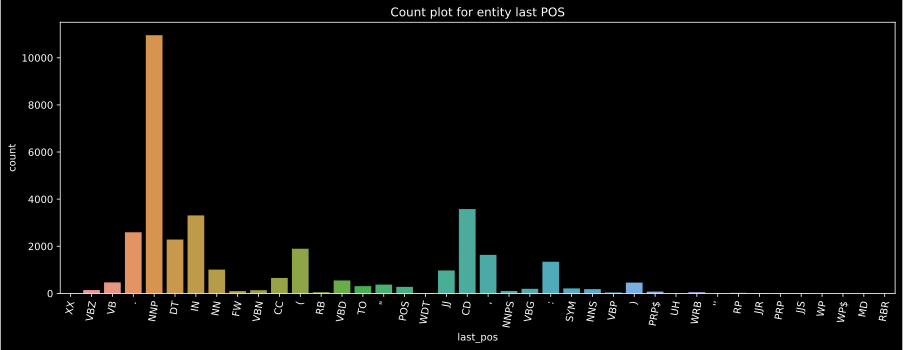

In [116]:
plt.figure(figsize=(15,5))
sns.countplot(entities_df['last_pos'])
plt.xticks(rotation = 80);
plt.title(f'Count plot for entity last POS')

/home/jonaf/projects/venvs/venv39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Count plot for entity next POS')

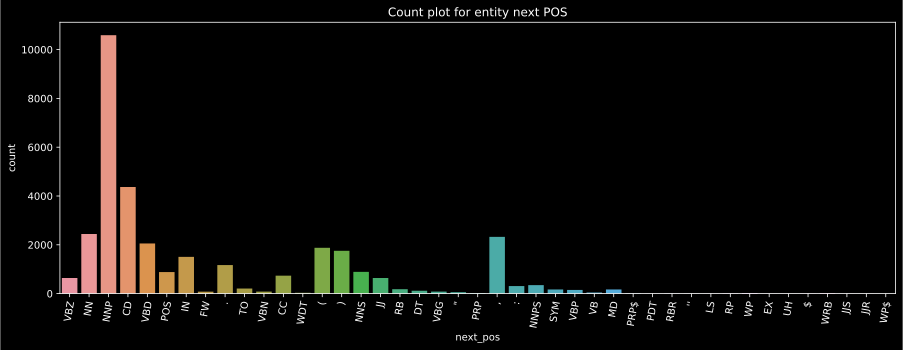

In [117]:
plt.figure(figsize=(15,5))
sns.countplot(entities_df['next_pos'])
plt.xticks(rotation = 80);
plt.title(f'Count plot for entity next POS')

/home/jonaf/projects/venvs/venv39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Count plot for NON entity next POS')

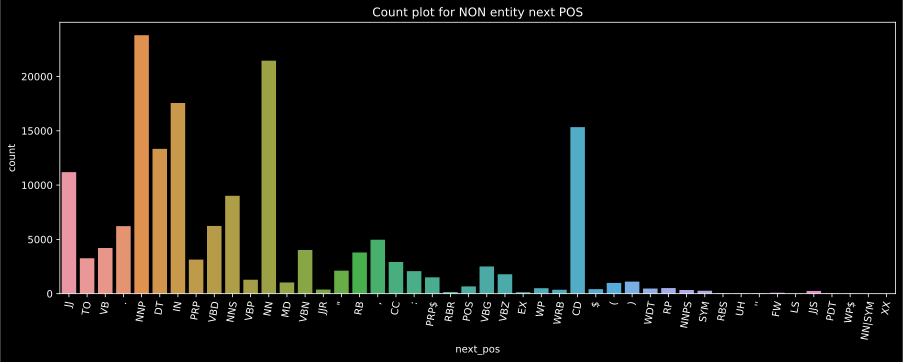

In [118]:
plt.figure(figsize=(15,5))
sns.countplot(non_entities_df['next_pos'])
plt.xticks(rotation = 80);
plt.title(f'Count plot for NON entity next POS')

In [21]:
plt.figure(figsize=(15,5))
sns.countplot(non_entities_df['last_pos'])
plt.xticks(rotation = 80);
plt.title(f'Count plot for NON entity last POS')

NameError: name 'non_entities_df' is not defined

<Figure size 1080x360 with 0 Axes>

In [22]:
plt.figure(figsize=(15,5))
sns.countplot(df['next_pos'], hue=df['y'])
plt.xticks(rotation = 80);
plt.title(f'Count plot for NON entity next POS')

NameError: name 'df' is not defined

<Figure size 1080x360 with 0 Axes>

In [23]:
plt.figure(figsize=(15,5))
sns.countplot(df['last_pos'], hue=df['y'])
plt.xticks(rotation = 80);
plt.title(f'Count plot for NON entity next POS')

NameError: name 'df' is not defined

<Figure size 1080x360 with 0 Axes>

In [24]:
sns.countplot(x=df['y'])

NameError: name 'df' is not defined

In [25]:
plt.figure(figsize=(15,5))

x,y = 'last_pos', 'y'

(df
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))

NameError: name 'df' is not defined

<Figure size 1080x360 with 0 Axes>

In [115]:
sentences_df['word len'] = sentences_df['word'].apply(len)

In [119]:
sentences_df['first letter'] = sentences_df['word'].apply(lambda w: w[0].lower())

In [120]:
sentences_df

,word,pos,label,sentence len,word len,first letter
0,EU,NNP,1,9,2,e
1,rejects,VBZ,0,9,7,r
2,German,JJ,1,9,6,g
3,call,NN,0,9,4,c
4,to,TO,0,9,2,t
...,...,...,...,...,...,...
203616,three,CD,0,2,5,t
203617,Swansea,NN,1,4,7,s
203618,1,CD,0,4,1,1
203619,Lincoln,NNP,1,4,7,l


In [28]:
np.corrcoef(sentences_df['word len'], sentences_df['label'])

array([[1.        , 0.29717946],
       [0.29717946, 1.        ]])

(0.0, 18.0)

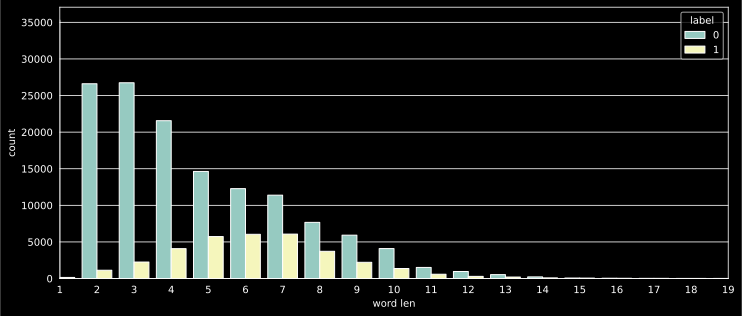

In [29]:
plt.figure(figsize=(12,5))
sns.countplot(data=sentences_df, x='word len', hue='label')
plt.xlim([0,18])

In [30]:
sentences_df

,word,pos,label,word len
0,EU,NNP,1,2
1,rejects,VBZ,0,7
2,German,JJ,1,6
3,call,NN,0,4
4,to,TO,0,2
...,...,...,...,...
203616,three,CD,0,5
203617,Swansea,NN,1,7
203618,1,CD,0,1
203619,Lincoln,NNP,1,7


(0.0, 30.0)

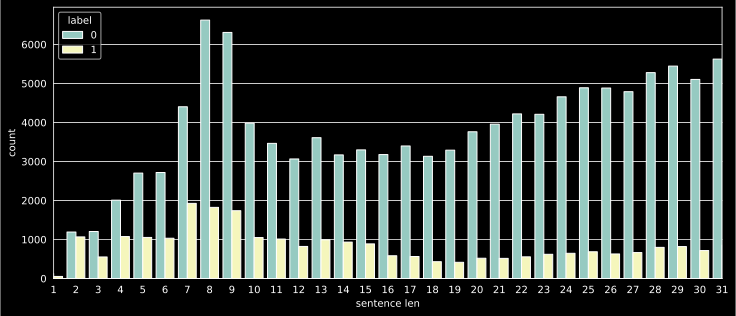

In [53]:
plt.figure(figsize=(12,5))
sns.countplot(data=sentences_df, x='sentence len', hue='label')
plt.xlim([0,30])

<AxesSubplot:xlabel='first letter', ylabel='count'>

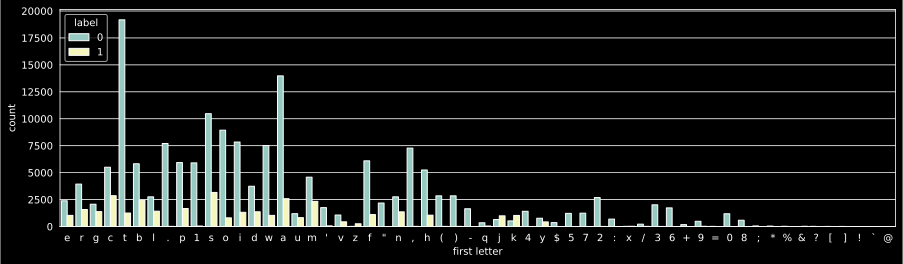

In [123]:
plt.figure(figsize=(15,4))
sns.countplot(data=sentences_df, x='first letter', hue='label')
# plt.xlim([0,18])

In [121]:
sentences_df

,word,pos,label,sentence len,word len,first letter
0,EU,NNP,1,9,2,e
1,rejects,VBZ,0,9,7,r
2,German,JJ,1,9,6,g
3,call,NN,0,9,4,c
4,to,TO,0,9,2,t
...,...,...,...,...,...,...
203616,three,CD,0,2,5,t
203617,Swansea,NN,1,4,7,s
203618,1,CD,0,4,1,1
203619,Lincoln,NNP,1,4,7,l


# Final 5 features

In [239]:
feature_maps = [lambda sentence: [word[0].isupper() for word in sentence[0]],                                       #0
                    lambda sentence: [True if pos in ('NNP', 'NNPS', 'JJS') else False for pos in sentence[1]],                      #2
                    lambda sentence: [True if pos in ('NN', 'CD', 'IN', 'DT') else False for pos in sentence[1]],   #3
                    lambda sentence: [len(word) for word in sentence[0]],                                           #6
                    lambda sentence: [len(sentence[0]) for word in sentence[0]],                                    #7
                    ]

In [240]:
X_train, y_train = dataloading.convert_raw_to_features(sentences_train, feature_maps)
X_eval, y_eval = dataloading.convert_raw_to_features(sentences_eval, feature_maps)
model = RandomForestClassifier(n_estimators=100, max_depth=13, random_state=42)
model.fit(X_train, y_train)
score = model.score(X_eval, y_eval)
score

0.9606129044819127

In [249]:
%config InlineBackend.figure_formats = ['svg']
import matplotlib
%matplotlib inline
matplotlib.style.use('dark_background')

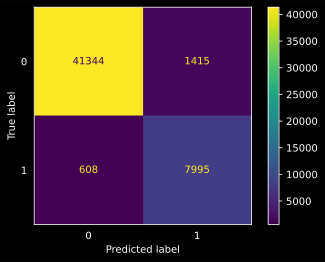

In [262]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_eval_hat = model.predict(X_eval)
cm = confusion_matrix(y_eval, y_eval_hat, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.grid()
plt.show()

In [281]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_eval, y_eval_hat)
recall = recall_score(y_eval, y_eval_hat)
f1 = f1_score(y_eval, y_eval_hat)
print(f'precision: {precision*100: 0.2f}%, recall: {recall*100: 0.2f}%, f1: {f1*100: 0.2f}%')

precision:  84.96%, recall:  92.93%, f1:  88.77%


In [275]:
ACC = (y_eval_hat == y_eval)
TP = ((y_eval_hat==1) & (y_eval==1)).sum()
TN = ((y_eval_hat==0) & (y_eval==0)).sum()
FP = ((y_eval_hat==1) & (y_eval==0)).sum()
FN = ((y_eval_hat==0) & (y_eval==1)).sum()

In [276]:
TP, TN, FP, FN

(7995, 41344, 1415, 608)

In [279]:
pr = TP / (TP + FP)
rc = TP / (TP + FN)
f1 = 0.5*(pr + rc)
pr, rc, f1

(0.8496280552603613, 0.9293269789608276, 0.8894775171105944)

In [259]:
(41344)/(41344+1415)

0.9669075516265582

In [260]:
(41344)/(41344+608)

0.9855072463768116